In [1]:
%matplotlib inline
import keras 
from keras.applications import xception
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from utils import breed_overview, store_data_hdf5, get_data_hdf5, hdf5_image_generator, get_steps, get_labels
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print tf.__version__

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


1.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13840887073446058418
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1321467904
locality {
  bus_id: 1
}
incarnation: 4652346522906062639
physical_device_desc: "device: 0, name: Quadro M1000M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [7]:
root_dir = "/home/anne/src/dog_identification/"  
train_zip = root_dir + "data/train.zip"
valid_zip = root_dir + "data/valid.zip"
training_filename = root_dir + "data/train.p"
validation_filename = root_dir + "data/valid.p"
labels_filename = root_dir + "data/labels.csv.zip"
hdf5_filename = root_dir + "data/images.hdf5"

num_validation = 0.3
batch_size = 15

n_breeds = None

nwidth = 80
nheight = 80

### Load datasets

In [3]:
# Load the whole dataset into memory
store_data_hdf5(train_zip, labels_filename, hdf5_filename,store_size=299, train_val=0.8)
# x_train, x_val, y_train, y_val, breed_dict = get_data_hdf5(hdf5_filename, n_breeds=n_breeds)

HDF5 file already exists, continueing


In [8]:
# y_val_hot = keras.utils.to_categorical(y_val)
# y_train_hot = keras.utils.to_categorical(y_train)



# print("Label frequency training set: max=%d, min=%d" % (np.amax(freq_train), np.amin(freq_train)))
# print("Label frequency validation set: max=%d, min=%d" % (np.amax(freq_val), np.amin(freq_val)))

# Create data flow objects
# nb_train_samples = x_train.shape[0]
# nb_val_samples = x_val.shape[0]

def preprocessing_function(img):
    return xception.preprocess_input(np.expand_dims(img.astype(float).copy(), axis=0))

# train_gen = ImageDataGenerator(preprocessing_function=preprocessing_function)
# train_gen.fit(x_train)
# train_flow = train_gen.flow(x_train, y_train_hot, batch_size=batch_size, shuffle=False)

# val_gen = ImageDataGenerator(preprocessing_function=preprocessing_function)
# val_gen.fit(x_val)
# val_flow =val_gen.flow(x_val, y_val_hot, batch_size=batch_size, shuffle=False)

# print x_train.shape
x_train_generator = hdf5_image_generator(hdf5_filename, batch_size=batch_size, n_breeds=n_breeds, image_preprocessor=preprocessing_function)
x_val_generator = hdf5_image_generator(hdf5_filename, batch_size=batch_size, n_breeds=n_breeds, image_preprocessor=preprocessing_function, training=False)

train_steps, val_steps = get_steps(hdf5_filename, batch_size=batch_size, n_breeds=n_breeds)

### Make sure images and labels are correct

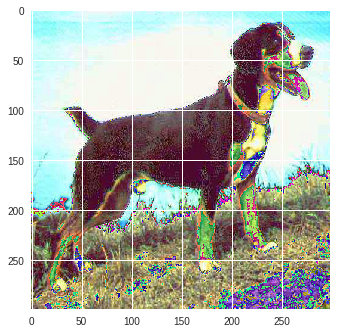

In [9]:
img_batch = x_train_generator.next()
# fig = plt.figure(1, figsize=(16, 16))
plt.imshow(img_batch[4,:,:,:])
plt.show()
# print breed_dict[label_batch[4].argmax()]


### Create model

In [9]:
xception_bottleneck = xception.Xception(weights = "imagenet", include_top=False, pooling='avg')


train_x_bf = xception_bottleneck.predict_generator(x_train_generator, steps=train_steps, verbose=1)
valid_x_bf = xception_bottleneck.predict_generator(x_val_generator, steps=val_steps, verbose=1)

print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

137/137 [==============================] - 100s 726ms/step
Xception train bottleneck features shape: (8177, 2048) size: 16,746,496
Xception valid bottleneck features shape: (2045, 2048) size: 4,188,160


### Modify pre-trained model

In [12]:
y_train, y_val, breed_dict = get_labels(hdf5_filename, 120)

y_val_hot = keras.utils.to_categorical(y_val)
y_train_hot = keras.utils.to_categorical(y_train)

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1987)
logreg.fit(train_x_bf, (y_train_hot * range(120)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print('Validation Xception LogLoss {}'.format(log_loss(y_val_hot, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((y_val_hot * range(120)).sum(axis=1), valid_preds)))

Validation Xception LogLoss 0.328594732373
Validation Xception Accuracy 0.894376528117


### Train generator

### Evaluate training

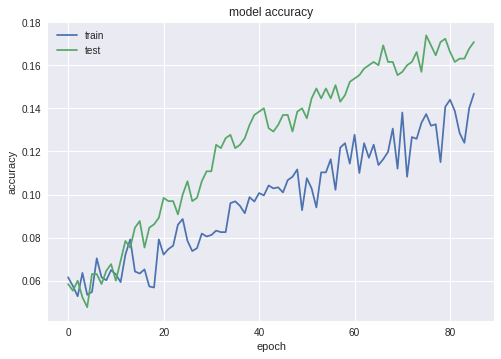

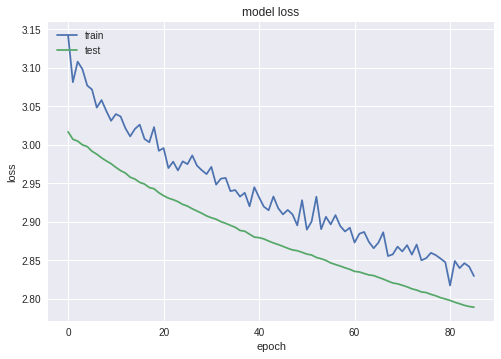

In [9]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()